In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


In [2]:
import os
import glob
import json
import pandas as pd

def report_model(path):
    info = torch.load(path, map_location='cpu')
    with open(f'{path[:-5]}_args.txt', 'r') as f:
        params = json.load(f)
    ret = {
        'path': path,
        'val_loss': info['val_loss'],
        'train_loss': info['train_loss'],
        'val_tmax': params['val_tmax'],
        'num_train_counties': params['num_train_counties']
    }
    return ret

records = []
for path in glob.glob('models/*.ckpt'):
    records.append(report_model(path))

df = pd.DataFrame.from_records(records, np.arange(len(records)))
df.sort_values('val_loss')

,path,val_loss,train_loss,val_tmax,num_train_counties
1,models/CensusForecasting_gridded.ckpt,0.252889,0.001654,40,0
4,models/CensusForecasting_3060833_all_counties....,0.391562,0.001536,10,31
2,models/CensusForecasting_3067365_all_counties....,0.399263,0.001496,10,31
3,models/CensusForecasting_3068103_all_counties....,0.403627,0.001507,10,31
0,models/CensusForecasting_3067366_all_counties....,0.412297,0.001567,10,31


# Neural network predictions

In [3]:
from census_dataset import CensusDataset
from scipy.interpolate import interp1d

def make_predictions_plot(model, county):
    dataset = CensusDataset(county).validate()
    wb1980 = dataset.wb(1980)
    wb2020 = dataset.wb(2020)

    # Neural network prediction
    batch = dataset[0]
    wb = batch['wb'].to(device)
    wb[wb.isnan()] = 0.
    with torch.no_grad():
        wbNN = model.simulate(wb[0:1], n_steps=40, dt=1)[0,-1].cpu().numpy()

    # Spline extrapolation
    spline = interp1d([1980, 1990], np.stack([dataset.wb(1980), dataset.wb(1990)]), axis=0, fill_value='extrapolate')
    wbSpline = spline(2020)

    # Another spline extrapolation which adjusts for housing
    spline = interp1d([1980, 1990], 
                      np.stack([dataset.wb(1980), dataset.wb(1990)]) * dataset.housing, 
                      axis=0, fill_value='extrapolate')
    wbSplineTimeSeries = spline(np.array([1980, 1990, 2000, 2010, 2020]))
    wbSplineTimeSeries[wbSplineTimeSeries < 0] = 0. # Cannot have negative residents

    housing = np.sum(wbSplineTimeSeries, axis=1).max(axis=0)
    wbSpline = spline(2020) / housing


    # Error rates
    mse_NN = np.mean(np.power(wbNN - wb2020, 2).sum(0)[dataset.mask])
    mse_Sp = np.mean(np.power(wbSpline - wb2020, 2).sum(0)[dataset.mask])
    mse_No = np.mean(np.power(wb1980 - wb2020, 2).sum(0)[dataset.mask])

    print(f'For county = {county}')
    print(f'---------------------------------')
    print(f'\tModel\t\t|   MSE  ')
    print(f'---------------------------------')
    print(f'Neural Network\t\t|  {mse_NN:.3f}')
    print(f'Spline extrapolation\t|  {mse_Sp:.3f}')
    print(f'No dynamics\t\t|  {mse_No:.3f}')

    alpha = np.ones(dataset.mask.shape)
    alpha[~dataset.mask] = 0.

    def plot(column, dataset, wb):
        prop = (wb[0] - wb[1]) / wb.sum(0)
        pc0 = column[0].pcolormesh(dataset.x, dataset.y, prop, vmin=-1, vmax=1, cmap='bwr_r', alpha=alpha)
        pc1 = column[1].pcolormesh(dataset.x, dataset.y,  wb[0], vmin=0, vmax=1, cmap='Blues', alpha=alpha)
        pc2 = column[2].pcolormesh(dataset.x, dataset.y,  wb[1], vmin=0, vmax=1, cmap='Reds', alpha=alpha)
        return pc0, pc1, pc2

    fig, ax = plt.subplots(3, 4, dpi=200)

    plot(ax[:,0], dataset, wb1980)
    plot(ax[:,1], dataset, wb2020)
    plot(ax[:,2], dataset, wbNN)
    pc0, pc1, pc2 = plot(ax[:,3], dataset, wbSpline)

    plt.rcParams['font.size'] = 8
    plt.rcParams['axes.titlesize'] = 8

    fig.colorbar(pc0, ax=ax[0,:], ticks=[-1,1]).set_ticklabels(['All\nblack', 'All\nwhite'], 
        rotation=90, verticalalignment='center', multialignment='center')
    fig.colorbar(pc1, ax=ax[1,:], ticks=[0,1], label='Fraction')
    fig.colorbar(pc2, ax=ax[2,:], ticks=[0,1], label='Fraction')

    ax[0,0].set_title('1980\ncensus data')
    ax[0,1].set_title('2020\ncensus data')
    ax[0,2].set_title('2020\nNN prediction')
    ax[0,3].set_title('2020\nSpline extrapolation')

    ax[0,0].set_ylabel('Resident\nproportion')
    ax[1,0].set_ylabel('White\noccupation')
    ax[2,0].set_ylabel('Black\noccupation')

    for a in ax.flatten():
        a.set(xticks=[], yticks=[], aspect='equal')

    return fig

Reached minimium loss of 0.392
For county = Georgia_Fulton
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.094
Spline extrapolation	|  0.378
No dynamics		|  0.243
For county = Illinois_Cook
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.055
Spline extrapolation	|  0.557
No dynamics		|  0.300
For county = Texas_Harris
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.145
Spline extrapolation	|  0.324
No dynamics		|  0.288
For county = California_Los Angeles
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.097
Spline extrapolation	|  0.474
No dynamics		|  0.242


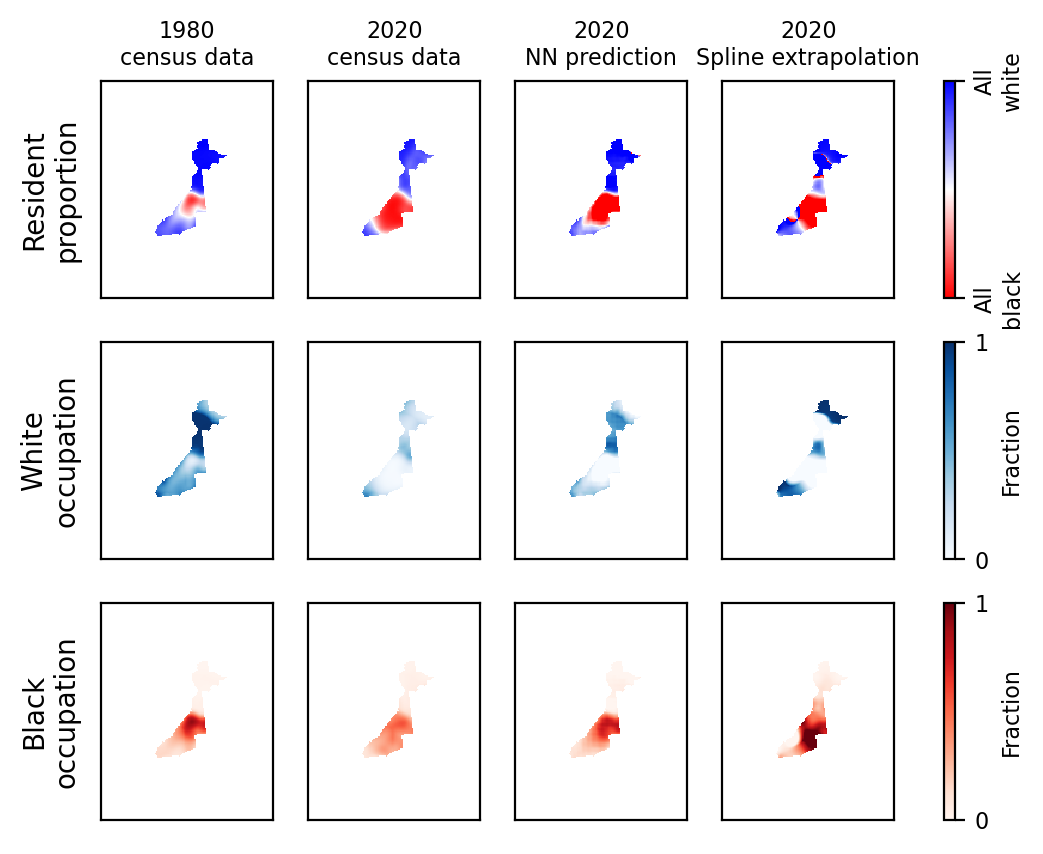

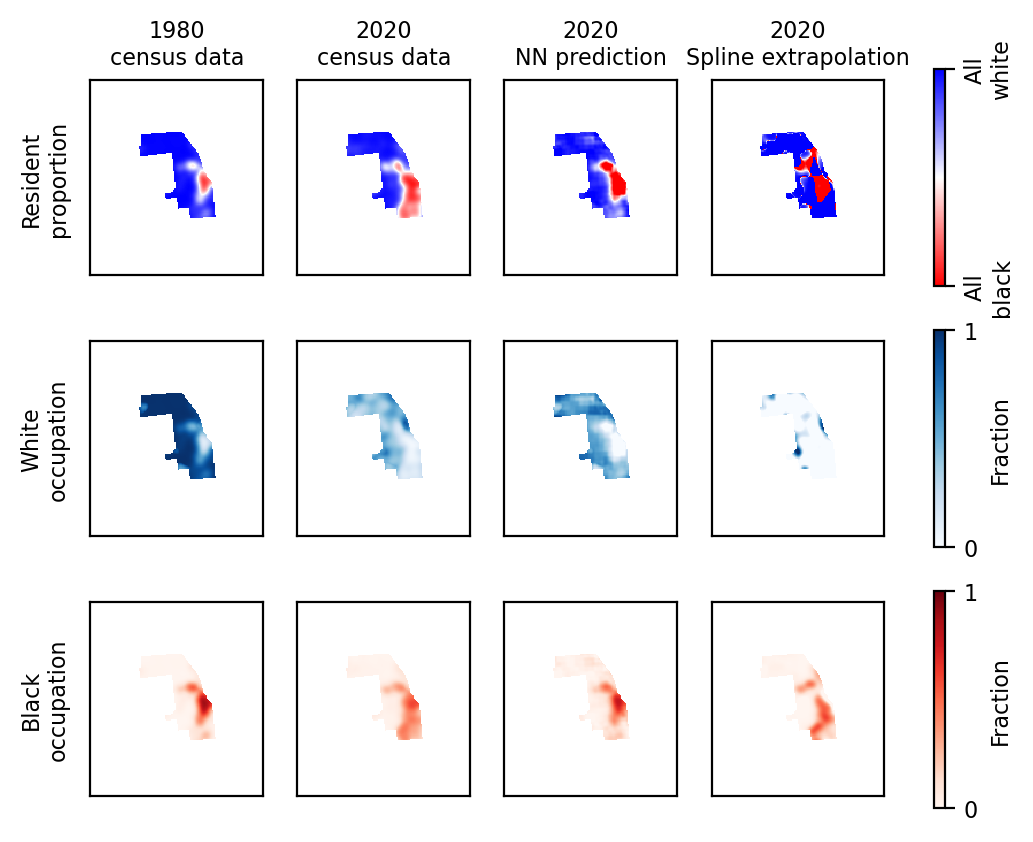

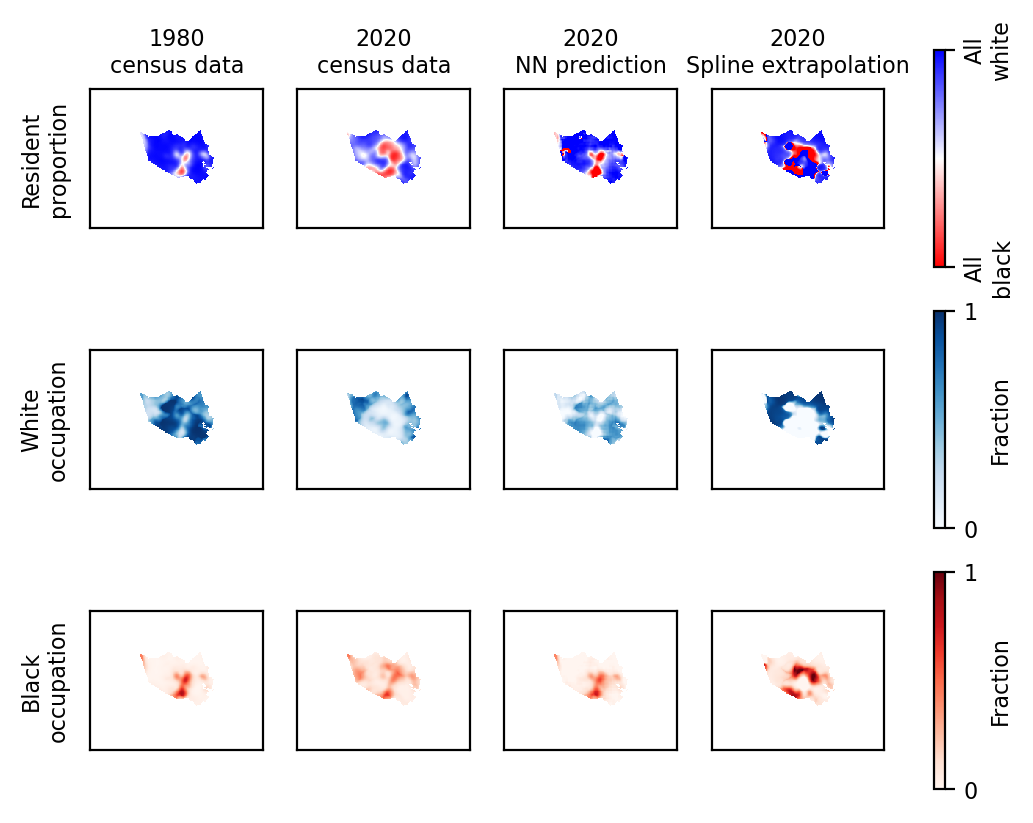

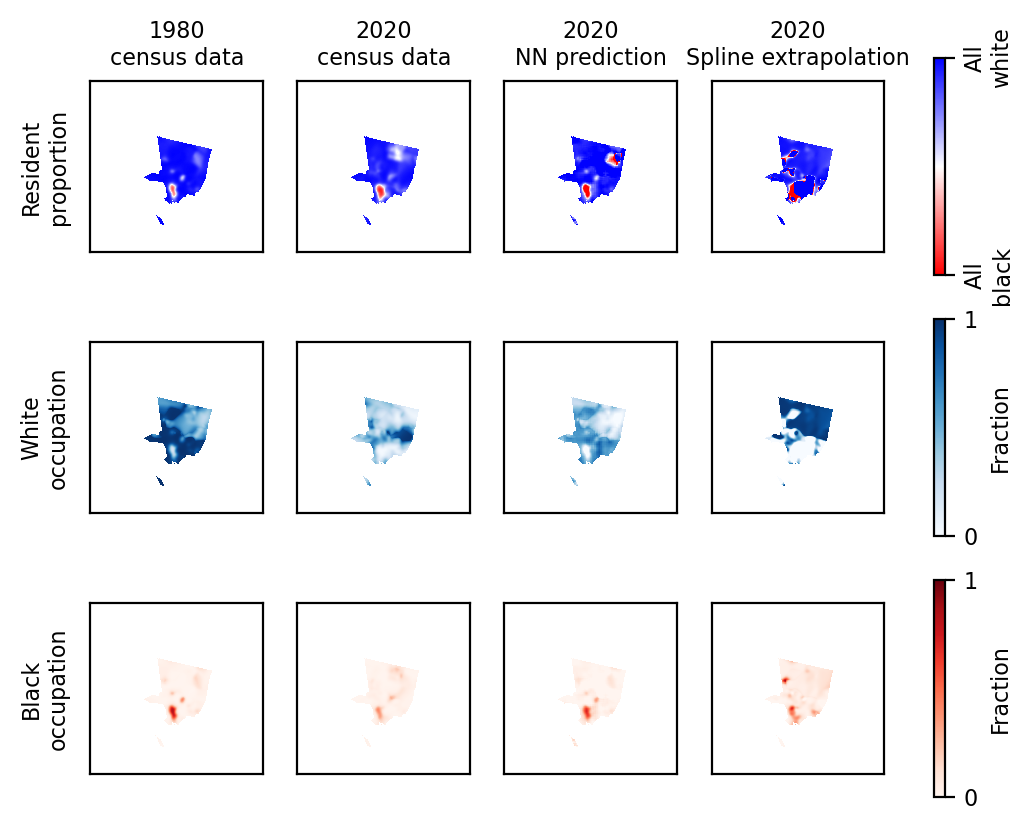

In [4]:
from census_nn import *

#model = 'CensusForecasting_gridded' # Legacy overfit model

model = 'CensusForecasting_3060833_all_counties' # Best-performing model trained on all counties

info = torch.load(f'models/{model}.ckpt')
print('Reached minimium loss of', np.round(info['val_loss'], 3), flush=True)

model = CensusForecasting().to(device)
model.eval()
model.load_state_dict(info['state_dict'], strict=False)

make_predictions_plot(model, 'Georgia_Fulton');
make_predictions_plot(model, 'Illinois_Cook');
make_predictions_plot(model, 'Texas_Harris');
make_predictions_plot(model, 'California_Los Angeles');